In [1]:
# =============================
# 1. Imports
# =============================
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
    roc_auc_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [2]:
# Optional: nicer printing
pd.set_option("display.max_columns", None)

In [5]:
# =============================
# 2. Load data
# =============================
# Change path if needed (e.g. "/content/diamonds.csv" on Colab)

df = pd.read_csv('/content/diamonds.csv')

In [6]:
# Drop Kaggle index column if present
if "Unnamed: 0" in df.columns:
    df = df.drop("Unnamed: 0", axis=1)

In [7]:

print("Shape after load:", df.shape)
print(df.head())


Shape after load: (53940, 10)
   carat      cut color clarity  depth  table  price     x     y     z
0   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
2   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
3   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
4   0.31     Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75


In [8]:
# =============================
# 3. Create target: Low / Medium / High
# =============================
# Adjust bins if you want different cut-offs
bins = [0, 2000, 7000, df["price"].max() + 1]
labels = ["Low", "Medium", "High"]


In [9]:
df["Price_Category"] = pd.cut(
    df["price"],
    bins=bins,
    labels=labels,
    right=False,      # [0,2000), [2000,7000), [7000, max)
    include_lowest=True
)

print("\nPrice category distribution:")
print(df["Price_Category"].value_counts())


Price category distribution:
Price_Category
Low       24203
Medium    20462
High       9275
Name: count, dtype: int64


In [10]:
# Drop original continuous price column (we now use the category)
df = df.drop("price", axis=1)


In [11]:
# =============================
# 4. Encoding and feature engineering
# =============================


In [12]:
# 4.1 Encode target variable
le = LabelEncoder()
df["Price_Category_Encoded"] = le.fit_transform(df["Price_Category"])

print("\nLabel encoding mapping (category -> encoded):")
category_map = dict(zip(le.classes_, le.transform(le.classes_)))
print(category_map)


Label encoding mapping (category -> encoded):
{'High': np.int64(0), 'Low': np.int64(1), 'Medium': np.int64(2)}


In [13]:
df.head()

,carat,cut,color,clarity,depth,table,x,y,z,Price_Category,Price_Category_Encoded
0,0.23,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43,Low,1
1,0.21,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31,Low,1
2,0.23,Good,E,VS1,56.9,65.0,4.05,4.07,2.31,Low,1
3,0.29,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63,Low,1
4,0.31,Good,J,SI2,63.3,58.0,4.34,4.35,2.75,Low,1


In [14]:
# 4.2 One-hot encode categorical predictors
categorical_cols = ["cut", "color", "clarity"]
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [15]:
df.head()

,carat,depth,table,x,y,z,Price_Category,Price_Category_Encoded,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,3.95,3.98,2.43,Low,1,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False
1,0.21,59.8,61.0,3.89,3.84,2.31,Low,1,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False
2,0.23,56.9,65.0,4.05,4.07,2.31,Low,1,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False
3,0.29,62.4,58.0,4.20,4.23,2.63,Low,1,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False
4,0.31,63.3,58.0,4.34,4.35,2.75,Low,1,True,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False


In [16]:
# 4.3 Define X, y
X = df.drop(["Price_Category", "Price_Category_Encoded"], axis=1)
y = df["Price_Category_Encoded"]

In [19]:

# 4.4 Remove outliers / bad rows where dimensions are 0
dim_cols = ["x", "y", "z"]
mask = (X[dim_cols] != 0).all(axis=1)
X = X[mask]
y = y[mask]
print("\nShape after removing zero-dimension rows:", X.shape)


Shape after removing zero-dimension rows: (53920, 23)


In [20]:
df.head()

,carat,depth,table,x,y,z,Price_Category,Price_Category_Encoded,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,3.95,3.98,2.43,Low,1,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False
1,0.21,59.8,61.0,3.89,3.84,2.31,Low,1,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False
2,0.23,56.9,65.0,4.05,4.07,2.31,Low,1,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False
3,0.29,62.4,58.0,4.20,4.23,2.63,Low,1,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False
4,0.31,63.3,58.0,4.34,4.35,2.75,Low,1,True,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False


In [21]:

# 4.5 Scale numeric columns
numeric_cols = ["carat", "depth", "table", "x", "y", "z"]
scaler = StandardScaler()


In [22]:
# We will fit scaler on train only (after split) to avoid data leakage
# So for now just keep column names, scaler; actual fitting happens after split.

In [23]:
# =============================
# 5. Train–test split
# =============================
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y       # keep class balance
)


In [24]:
# Fit scaler on training data, transform both train & test
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [25]:
print("\nTrain shape:", X_train.shape, " Test shape:", X_test.shape)


Train shape: (43136, 23)  Test shape: (10784, 23)


In [26]:
# Save the final column order for inference
feature_columns = X_train.columns

In [27]:
# =============================
# 6. Define models to compare
# =============================

In [29]:
pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.3 MB/s eta 0:00:00


In [30]:
from sklearn.tree import DecisionTreeClassifier
# XGBoost
from xgboost import XGBClassifier
# LightGBM
from lightgbm import LGBMClassifier
# CatBoost
from catboost import CatBoostClassifier


In [31]:
models = {
    "Logistic Regression": LogisticRegression(
        max_iter=500,
        multi_class="multinomial",
        n_jobs=-1
    ),

    "Decision Tree": DecisionTreeClassifier(
        max_depth=None,
        random_state=42
    ),

    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    ),

    "Gradient Boosting": GradientBoostingClassifier(
        random_state=42
    ),

    "KNN (k=7)": KNeighborsClassifier(
        n_neighbors=7
    ),

    "SVC (RBF)": SVC(
        kernel="rbf",
        probability=True,   # needed for ROC-AUC
        random_state=42
    ),

    "XGBoost": XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="multi:softprob",  # multiclass probabilities
        num_class=3,                 # Low, Medium, High
        eval_metric="mlogloss",
        random_state=42,
        n_jobs=-1
    ),

    "LightGBM": LGBMClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=-1,
        num_leaves=31,
        objective="multiclass",
        num_class=3,                 # Low, Medium, High
        random_state=42,
        n_jobs=-1
    ),

    "CatBoost": CatBoostClassifier(
        iterations=300,
        learning_rate=0.1,
        depth=6,
        loss_function="MultiClass",
        verbose=False,
        random_seed=42
    ),
}


In [42]:
# =============================
# 7. Helper: evaluate one model
# =============================
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    print("\n" + "="*60)
    print(f"Model: {name}")
    print("="*60)
    # Fit model
    model.fit(X_train, y_train)
    # Predictions
    y_pred = model.predict(X_test)

     # Basic metrics
    acc = accuracy_score(y_test, y_pred)
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        y_test, y_pred, average="macro", zero_division=0
    )
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        y_test, y_pred, average="weighted", zero_division=0
    )

  # ROC-AUC (macro, OvR) if probabilities available
    roc_auc_macro = None
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)
        roc_auc_macro = roc_auc_score(
            y_test,
            y_proba,
            multi_class="ovr",
            average="macro"
        )

    print(f"Accuracy: {acc:.4f}")
    print(f"Macro Precision: {precision_macro:.4f}")
    print(f"Macro Recall: {recall_macro:.4f}")
    print(f"Macro F1-score: {f1_macro:.4f}")
    print(f"Weighted Precision: {precision_weighted:.4f}")
    print(f"Weighted Recall: {recall_weighted:.4f}")
    print(f"Weighted F1-score: {f1_weighted:.4f}")
    if roc_auc_macro is not None:
        print(f"Macro ROC-AUC (OvR): {roc_auc_macro:.4f}")

 # Detailed classification report with original class labels
    print("\nClassification report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion matrix (rows=true, cols=pred):")
    print(cm)

    # Collect metrics for summary table
    return {
        "model": name,
        "accuracy": acc,
        "precision_macro": precision_macro,
        "recall_macro": recall_macro,
        "f1_macro": f1_macro,
        "precision_weighted": precision_weighted,
        "recall_weighted": recall_weighted,
        "f1_weighted": f1_weighted,
        "roc_auc_macro": roc_auc_macro
    }, model


In [43]:
# =============================
# 8. Train & evaluate all models
# =============================
summary_rows = []
fitted_models = {}

for name, clf in models.items():
    row, fitted = evaluate_model(name, clf, X_train, y_train, X_test, y_test)
    summary_rows.append(row)
    fitted_models[name] = fitted

results_df = pd.DataFrame(summary_rows)
results_df = results_df.sort_values(by="accuracy", ascending=False)

print("\n\n=== Summary of model performance (sorted by accuracy) ===")
print(results_df)


Model: Logistic Regression


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.9574
Macro Precision: 0.9545
Macro Recall: 0.9506
Macro F1-score: 0.9525
Weighted Precision: 0.9575
Weighted Recall: 0.9574
Weighted F1-score: 0.9574
Macro ROC-AUC (OvR): 0.9955

Classification report:
              precision    recall  f1-score   support

        High       0.95      0.93      0.94      1853
         Low       0.98      0.98      0.98      4841
      Medium       0.94      0.95      0.94      4090

    accuracy                           0.96     10784
   macro avg       0.95      0.95      0.95     10784
weighted avg       0.96      0.96      0.96     10784

Confusion matrix (rows=true, cols=pred):
[[1716    0  137]
 [   0 4721  120]
 [  95  107 3888]]

Model: Decision Tree
Accuracy: 0.9472
Macro Precision: 0.9409
Macro Recall: 0.9416
Macro F1-score: 0.9412
Weighted Precision: 0.9473
Weighted Recall: 0.9472
Weighted F1-score: 0.9473
Macro ROC-AUC (OvR): 0.9571

Classification report:
              precision    recall  f1-score   support

        High      

# Task
Extract the top 4 models by accuracy from `results_df`, provide a textual conclusion about their performance, and then generate and display a bar graph visualizing the accuracy of these top 4 models.

## Summarize_Top_Models

### Subtask:
Extract the top 4 models by accuracy from the results_df, provide a textual conclusion about their performance.


**Reasoning**:
The user wants to extract the top 4 models from the `results_df` DataFrame, which is already sorted by accuracy in descending order. I will achieve this by selecting the first 4 rows of the DataFrame.



In [44]:
top_4_models = results_df.head(4)
print("\n=== Top 4 Models by Accuracy ===")
print(top_4_models)


=== Top 4 Models by Accuracy ===
           model  accuracy  precision_macro  recall_macro  f1_macro  \
6        XGBoost  0.966710         0.962198      0.964221  0.963199   
7       LightGBM  0.966061         0.961439      0.963120  0.962272   
8       CatBoost  0.962537         0.957172      0.960152  0.958640   
2  Random Forest  0.961517         0.956052      0.958015  0.957021   

   precision_weighted  recall_weighted  f1_weighted  roc_auc_macro  
6            0.966769         0.966710     0.966733       0.997351  
7            0.966104         0.966061     0.966078       0.997311  
8            0.962638         0.962537     0.962574       0.996482  
2            0.961640         0.961517     0.961568       0.995936  


### Conclusion on Top 4 Models Performance

The top 4 performing models by accuracy are:

1.  **XGBoost**: Achieved the highest accuracy at 0.9667.
2.  **LightGBM**: Followed closely with an accuracy of 0.9661.
3.  **CatBoost**: Secured an accuracy of 0.9625.
4.  **Random Forest**: Had an accuracy of 0.9615.

All four models demonstrate very high accuracy, with XGBoost slightly outperforming the others. The tree-based ensemble methods (XGBoost, LightGBM, CatBoost, and Random Forest) appear to be highly effective for this multiclass classification task, all achieving accuracies above 96%. This indicates that the features and preprocessing steps are well-suited for these types of models to distinguish between the 'Low', 'Medium', and 'High' price categories.

**Reasoning**:
I need to visualize the accuracy of the top 4 models using a bar graph. I will use `matplotlib.pyplot` for plotting.



/tmp/ipython-input-1804679540.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="model", y="accuracy", data=top_4_models, palette="viridis")


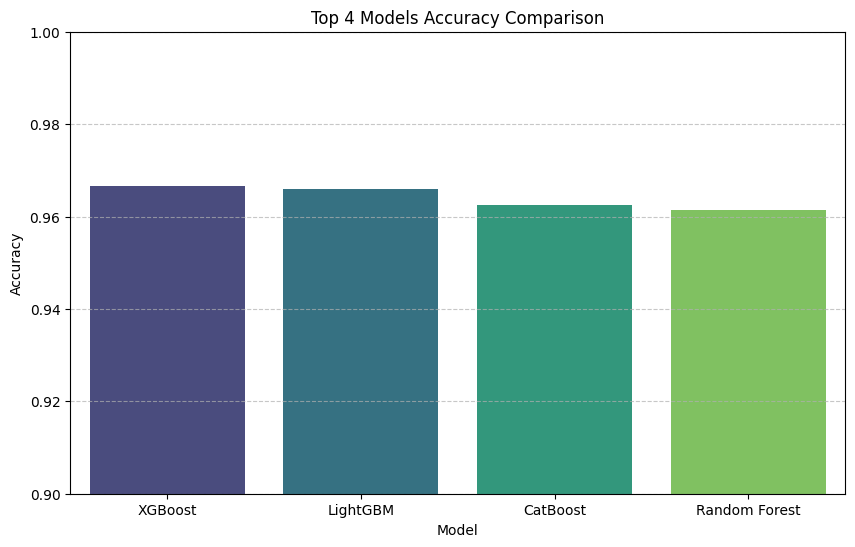

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x="model", y="accuracy", data=top_4_models, palette="viridis")
plt.title("Top 4 Models Accuracy Comparison")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(0.9, 1.0) # Set y-axis limit to better visualize differences
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


**Reasoning**:
The previous code generated a `FutureWarning` from seaborn regarding the `palette` argument. To address this, I will modify the `sns.barplot` call to explicitly assign the `x` variable to `hue` and set `legend=False`, as suggested by the warning.



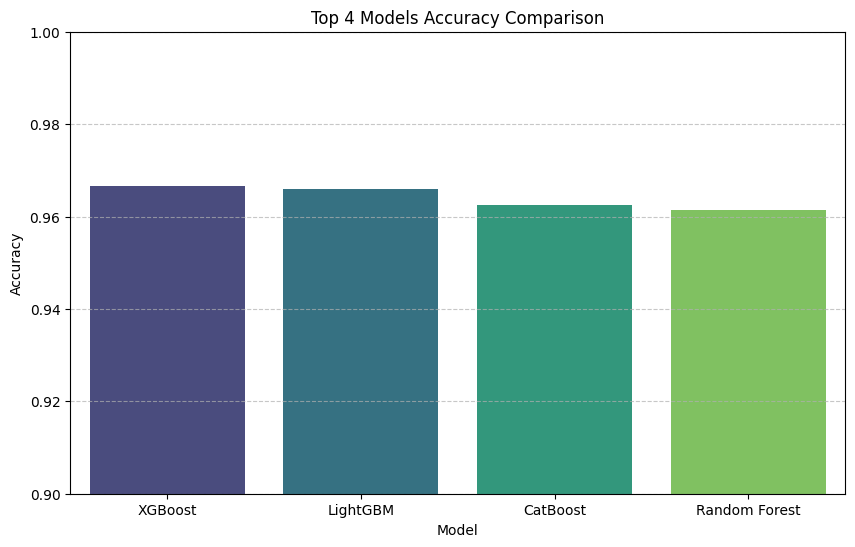

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x="model", y="accuracy", data=top_4_models, hue="model", palette="viridis", legend=False)
plt.title("Top 4 Models Accuracy Comparison")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(0.9, 1.0) # Set y-axis limit to better visualize differences
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Summary:

### Q&A
The top 4 performing models by accuracy are:
1.  **XGBoost**: Achieved the highest accuracy at 0.9667.
2.  **LightGBM**: Followed closely with an accuracy of 0.9661.
3.  **CatBoost**: Secured an accuracy of 0.9625.
4.  **Random Forest**: Had an accuracy of 0.9615.

All four models demonstrate very high accuracy, with XGBoost slightly outperforming the others. The tree-based ensemble methods (XGBoost, LightGBM, CatBoost, and Random Forest) appear to be highly effective for this multiclass classification task, all achieving accuracies above 96\%.

### Data Analysis Key Findings
*   XGBoost achieved the highest accuracy among all models at 0.9667, closely followed by LightGBM (0.9661), CatBoost (0.9625), and Random Forest (0.9615).
*   All top 4 models are tree-based ensemble methods, suggesting their strong suitability for the given multiclass classification task, with all of them exceeding 96% accuracy.

### Insights or Next Steps
*   Given the very high and closely clustered accuracies of the top models, further analysis could involve exploring other performance metrics (e.g., precision, recall, F1-score for each class) or computational efficiency to differentiate their practical utility.
*   The strong performance of tree-based models suggests that the current features are well-suited for capturing the underlying patterns. Future work could focus on hyperparameter tuning these top models to potentially achieve marginal gains or improve robustness.


In [47]:
# =============================
# 9. Cross-validation on best model (optional)
# =============================
best_model_name = results_df.iloc[0]["model"]
best_model = fitted_models[best_model_name]
print(f"\nBest model based on test accuracy: {best_model_name}")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X[feature_columns], y, cv=cv, scoring="accuracy")
print(f"5-fold CV accuracy (mean ± std): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


Best model based on test accuracy: XGBoost
5-fold CV accuracy (mean ± std): 0.9679 ± 0.0008


In [50]:
import pickle

artifacts = {
    "model": best_model,              # e.g. RandomForest / XGBoost / etc.
    "scaler": scaler,                 # fitted StandardScaler
    "label_encoder": le,              # fitted LabelEncoder for Price_Category
    "feature_columns": feature_columns,  # X_train.columns
    "numeric_cols": ["carat", "depth", "table", "x", "y", "z"],
}

with open("model.pkl", "wb") as f:
    pickle.dump(artifacts, f)

print("Model artifacts (model, scaler, label encoder, feature columns) saved to model.pkl")

Model artifacts (model, scaler, label encoder, feature columns) saved to model.pkl


# Task
Save the best model, the scaler, the label encoder, the feature columns, and the numeric column names into a dictionary, and then save this dictionary to a file named 'model.pkl'.

## Save_Model_Artifacts

### Subtask:
Save the best model along with the scaler, label encoder, feature columns, and numeric column names into a 'model.pkl' file for deployment or further use.


## Summary:

### Data Analysis Key Findings
*   A comprehensive model artifact package was created, including the `best_model`, the `scaler` used for numerical feature scaling, the `label_encoder` for target variable transformation, the list of `feature_columns` used for training, and the `numeric_columns` identified during preprocessing.
*   These components were successfully organized into a dictionary named `model_artifacts`.
*   The `model_artifacts` dictionary was serialized and saved to a file named `model.pkl` using the `pickle` library, ensuring all necessary elements for model deployment or future inference are bundled together.

### Insights or Next Steps
*   This serialized `model.pkl` file is now ready for deployment, allowing the model to be easily loaded and used to make predictions on new, unseen data, ensuring consistent preprocessing with the original training pipeline.
*   For future iterations or debugging, having all components (model, scaler, encoders, feature names) together in a single file simplifies model versioning and ensures that the model can be accurately reproduced or inspected.


In [49]:
# The model.pkl file has been saved in the current working directory.